In [2]:
import requests
import tornado
import matplotlib
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import  keras 
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from numpy import sqrt

# example of a model defined with the functional api
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt

#Test_Probno
EPOCHS=100
STEPEN_UCENJA=0.001
BATCH_SIZE=32
VERBOSE=2
MOMENTUM=0.8

#Funkcije za rad sa tensorom imace u nazivu t_
def t_normalize(df, mean):
  # Normalize data
  data = tf.cast(df, tf.float32) * 1 / (2 * mean)
  return tf.reshape(data, [-1, 1])

#Normalizovati za datu kolonu
def normalize_1(df,i):
  x = df[i]
  mean = np.mean(x)
  std = np.std(x)
  return ((df-mean)/std)

In [3]:

#Ucitavanje csv fajla pomocu tensorFunkcije
def putnja(filepath,ime_fajla):
    path=os.getcwd()+  "\\" + ime_fajla
    return path

def t_get_dataset(file_path):
  dataset = tf.data.experimental.make_csv_dataset(
      path,
      batch_size=10,  
      label_name='#',
      na_value="!",
      num_epochs=2,
      ignore_errors=True)
  return dataset

def ucitaj_sredjeno(dataset):
  for batch, oznaka in dataset.take(1):
    #oznaka je dictoanry
   for key, value in batch.items():
      print("{:5s}: {}".format(key,value.numpy()))

path=putnja(".","Pokemon.csv")
pokemon=t_get_dataset(path)
ucitaj_sredjeno(pokemon)


#Mozemo i preko pandasa

def vrat_dataset(putanja):
    return pd.read_csv(putanja)

pokemon1=vrat_dataset(path)
print(pokemon1.head(10))




Name : [b'Nuzleaf' b'Spiritomb' b'Clawitzer' b'Zebstrika' b'Lumineon' b'Cradily'
 b'Scraggy' b'Lapras' b'Pidgey' b'Regice']
Type 1: [b'Grass' b'Ghost' b'Water' b'Electric' b'Water' b'Rock' b'Dark' b'Water'
 b'Normal' b'Ice']
Type 2: [b'Dark' b'Dark' b'' b'' b'' b'Grass' b'Fighting' b'Ice' b'Flying' b'']
Total: [340 485 500 497 460 495 348 535 251 580]
HP   : [ 70  50  71  75  69  86  50 130  40  80]
Attack: [ 70  92  73 100  69  81  75  85  45  50]
Defense: [ 40 108  88  63  76  97  70  80  40 100]
Sp. Atk: [ 60  92 120  80  69  81  35  85  35 100]
Sp. Def: [ 40 108  89  63  86 107  70  95  35 200]
Speed: [ 60  35  59 116  91  43  48  60  56  50]
Generation: [3 4 6 5 4 3 5 1 1 3]
Legendary: [b'False' b'False' b'False' b'False' b'False' b'False' b'False' b'False'
 b'False' b'True']
   #                       Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1                  Bulbasaur  Grass  Poison    318  45      49       49   
1  2                    Ivysaur  Grass  Poison    40

In [4]:
def nedostajuce_vrednost(df,flg):

    if(flg):
        df=df[df.columns[df.isnull().mean() < 0.8]]
    else:
        df=df[df.columns[df.isnull().mean()<0.5]]
    return df

pokemon1=nedostajuce_vrednost(pokemon1,1)


def bool_to_int(df):
    #variable_name = {'True' : 0 , 'False' : 1 }

    for i in df.columns:
        if(df[i].dtype=='bool'):
             df[i] = df[i].astype(int)  
    return df


def tip_promenljivhi(df):
    numerickaKolona = df.select_dtypes("number").columns
    kategorijskaKolona = df.select_dtypes("object").columns
    numCols= list(set(numerickaKolona))
    catCols= list(set(kategorijskaKolona))

    return numCols,catCols

# Transofrmisali boolea to int i izdvojli kategorijske i numericke promenljive
pokemon1=bool_to_int(pokemon1)
kat,num=tip_promenljivhi(pokemon1)

#Pretvaram sve vrednosti u float32 potrebno za tensor i izdvajam numericke prom
def to_f32(df,kat):
    prvi=dict()
    for i in df.columns:
        if(df[i].dtypes!=np.float32 and i in kat):
            prvi[i]=df[i].astype(np.float32)
    return pd.DataFrame(prvi)    

pokemon1_num=to_f32(pokemon1,kat)







In [5]:
#funkcija vraca strdnje vrednosti za svaku numericku promenljivu
def mean_vrednosti(dt,kat):
    srednja=dict()
    for i in dt.columns:
        if i in kat:
            srednja[i]=dt[i].mean()
    return pd.DataFrame([srednja])


print(mean_vrednosti(pokemon1,kat))

#Min and Max skaliranje
def predProcesiraj(df):
    d=pd.DataFrame()
    for i in df.columns:
        max = df[i].max()
        min = df[i].min()
        print(max,min)
        df[i] = (df[i] - min) / (max - min)
    return df

pokemon1_num=predProcesiraj(pokemon1_num)

print(pokemon1_num.head(10))

#Samo ispod granice featurea error1 jos resavam
def one_hot_encoding(df,feature):
    encoder = OneHotEncoder(handle_unknown='ignore')
    jedinstene=df.nunique()
    #print(jedinstene)
    ceo=df
    d=pd.DataFrame()
    #print(len(ceo.columns))
    for i in df.columns:
        if(jedinstene[i]<=feature):
            encoder_df = pd.DataFrame(encoder.fit_transform(df[[i]]).toarray())
            #print(encoder_df)
            ceo=df.join(encoder_df)
            del ceo[i]
            #print(ceo)
            #print(ceo.head(20))
            #print(len(ceo.columns))
    return ceo


#Basic ciste da vidim kakvi su podaci
def prikazi_histograme(df,n_bins):
    hist=df.hist(bins=n_bins)
    print(hist)

#print(model.get_weights().head())
def otkloni_outlier(df, naziv_kolone):

    q1 = df[naziv_kolone].quantile(0.25)
    q3 = df[naziv_kolone].quantile(0.75)

    IQR = q3-q1 

    donja_granica  = q1-1.5*IQR
    gronja_granica = q3+1.5*IQR

    df_izlaz = df.loc[(df[naziv_kolone] > donja_granica) & (df[naziv_kolone] < gronja_granica)]

    return df_izlaz
    
def LabelEncode(df):
        konaZaEknodiranje = list(df.select_dtypes(include=['category','object']))
        le = LabelEncoder()
        for feature in konaZaEknodiranje:
            try:
                df[feature] = le.fit_transform(df[feature])
            except:
                print('Greska za promenljivu '+feature)
        return df


#prikazi_histograme(pokemon1_num,30)

pokemon=LabelEncode(pokemon1)
#pokemon1_num.boxplot()






           #     Total        HP    Attack  Defense  Sp. Atk  Sp. Def  \
0  362.81375  435.1025  69.25875  79.00125  73.8425    72.82  71.9025   

     Speed  Generation  Legendary  
0  68.2775     3.32375    0.08125  
721.0 1.0
780.0 180.0
255.0 1.0
190.0 5.0
230.0 5.0
194.0 10.0
230.0 20.0
180.0 5.0
6.0 1.0
1.0 0.0
          #     Total        HP    Attack   Defense   Sp. Atk   Sp. Def  \
0  0.000000  0.230000  0.173228  0.237838  0.195556  0.298913  0.214286   
1  0.001389  0.375000  0.232283  0.308108  0.257778  0.380435  0.285714   
2  0.002778  0.575000  0.311024  0.416216  0.346667  0.489130  0.380952   
3  0.002778  0.741667  0.311024  0.513514  0.524444  0.608696  0.476190   
4  0.004167  0.215000  0.149606  0.254054  0.168889  0.271739  0.142857   
5  0.005556  0.375000  0.224409  0.318919  0.235556  0.380435  0.214286   
6  0.006944  0.590000  0.303150  0.427027  0.324444  0.538043  0.309524   
7  0.006944  0.756667  0.303150  0.675676  0.471111  0.652174  0.309524   
8  0.0

In [19]:
#U nasem slucaj uzimam poslednji vrednost za nezavisnu
def zavisne_nezavine(df):
      x, y = df.values[:, :-1], df.values[:, -1]
      return x,y
      

def split_data(x,y,size):
    if(size/10>1):
        return "Mora vrednost manja od 1"
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=size/10)
    return [x_train,x_test,y_train,y_test]

def broj_ulaznih_promeljvih(x_train):
    return x_train.shape[1]

def vidi_grafickI_model(model):
    plot_model(model, 'model.png', show_shapes=True)


from tensorflow.keras import regularizers


#Model
def get_model(broj_slojeva,ulazne_vrednost,stepen_ucenja,momentum,epochs,barth_size,x_train,y_train,x_test,y_test):

    model=Sequential()

    model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(ulazne_vrednost,), activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    for i in broj_slojeva:
        #Batch normlizacija moze da utice na pooljanje samog modela
        model.add(BatchNormalization())
        model.add(Dense(i, activation='relu', kernel_initializer='he_normal',activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
    
    model.add(Dense(1, activation='relu'))

    #Optimizator
    sgd = SGD(learning_rate=stepen_ucenja, momentum=momentum)
    #model.compile(optimizer=sgd, loss='binary_crossentropy')
# fit the model
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

    mse, mae = model.evaluate(x_test, y_test, verbose=0)
    print('MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), mae))
    
    print("Probaj na testnom skupu")

    train_mse = model.evaluate(x_train, y_train, verbose=0)
    test_mse = model.evaluate(x_test, y_test, verbose=0) 
    print(train_mse)
    print(test_mse)



    return model




x,y=zavisne_nezavine(pokemon1_num)

x_train,x_test,y_train,y_test=split_data(x,y,6)


ulazne_vrednost=broj_ulaznih_promeljvih(x_train)

# Pravljene osnovnog modela
model=get_model([8],ulazne_vrednost,STEPEN_UCENJA,MOMENTUM,EPOCHS,BATCH_SIZE,x_train,y_train,x_test,y_test)

print(model.summary())

vidi_grafickI_model(model)





MSE: 0.275, RMSE: 0.524, MAE: 0.921
Probaj na testnom skupu
[0.34684136509895325, 0.9125000238418579]
[0.27471619844436646, 0.9208333492279053]
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 10)                100       
                                                                 
 batch_normalization_12 (Bat  (None, 10)               40        
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 8)                 88        
                                                                 
 dense_41 (Dense)            (None, 1)                 9         
                                                                 
Total params: 237
Trainable params: 217
Non-trainable params: 20
__________________________________________

2.8.0

Epoch 1: saving model to modeli_cpkt

Epoch 2: saving model to modeli_cpkt

Epoch 3: saving model to modeli_cpkt

Epoch 4: saving model to modeli_cpkt

Epoch 5: saving model to modeli_cpkt

Epoch 6: saving model to modeli_cpkt

Epoch 7: saving model to modeli_cpkt

Epoch 8: saving model to modeli_cpkt

Epoch 9: saving model to modeli_cpkt

Epoch 10: saving model to modeli_cpkt

Epoch 11: saving model to modeli_cpkt

Epoch 12: saving model to modeli_cpkt

Epoch 13: saving model to modeli_cpkt

Epoch 14: saving model to modeli_cpkt

Epoch 15: saving model to modeli_cpkt

Epoch 16: saving model to modeli_cpkt

Epoch 17: saving model to modeli_cpkt

Epoch 18: saving model to modeli_cpkt

Epoch 19: saving model to modeli_cpkt

Epoch 20: saving model to modeli_cpkt

Epoch 21: saving model to modeli_cpkt

Epoch 22: saving model to modeli_cpkt

Epoch 23: saving model to modeli_cpkt

Epoch 24: saving model to modeli_cpkt

Epoch 25: saving model to modeli_cpkt

Epoch 26: saving model to m

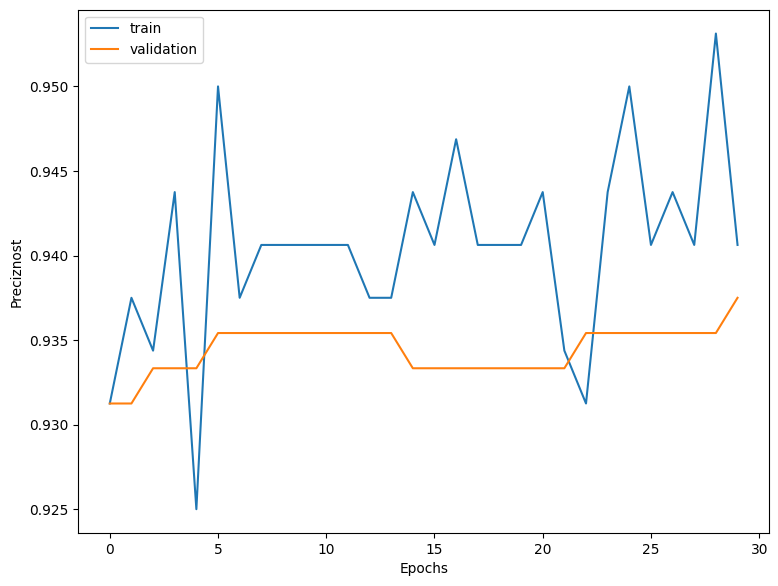

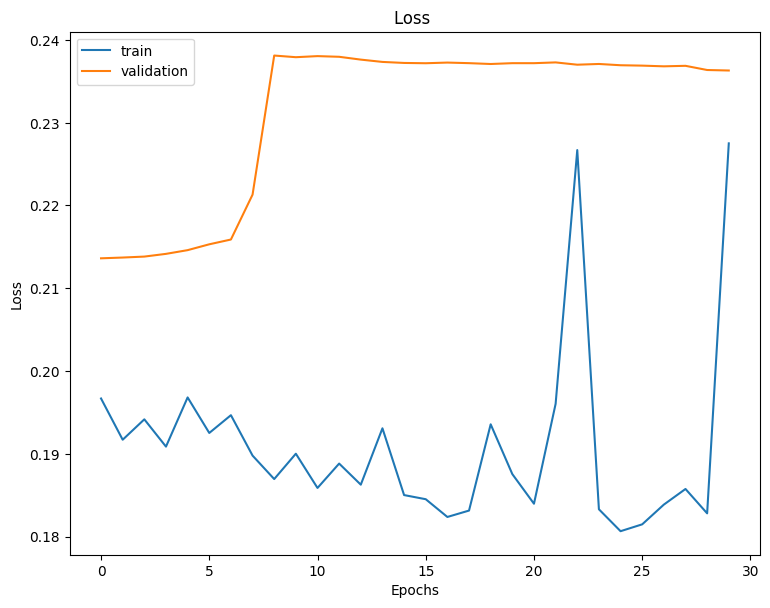

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


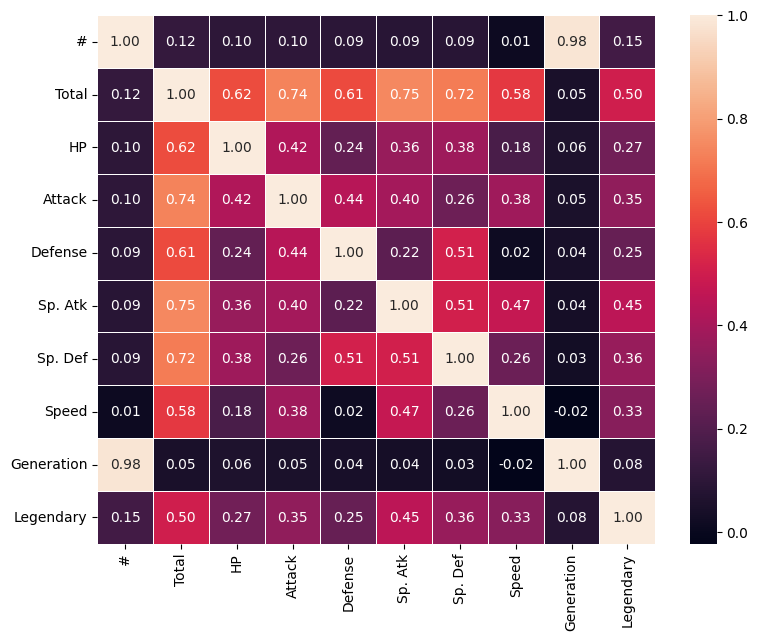

In [20]:
from matplotlib import pyplot
from numpy import loadtxt
from keras.models import load_model

print(tf.version.VERSION)

#Sloj kome se zadaje tezina,i vrednosti
class LogLayer(keras.layers.Layer):
    def __init__(self,name=None):
        super(LogLayer, self).__init__(name=name)
        #funkcija gubitka
        self.loss_fun = keras.losses.BinaryCrossentropy(from_logits=True)
        #kros entropija
        self.accuracy_fn = keras.metrics.BinaryAccuracy()
    def call(self, targets, logits, tezina=None):
        loss=self.loss_fun(targets,logits,tezina)
        self.add_loss()
        acc = self.accuracy_fn(targets, logits, tezina)
        self.add_metric(acc, name="accuracy")
        return tf.nn.softmax(logits)

#Funkcija loss
def loss(target_y, predicted_y):
  return tf.reduce_mean(tf.square(target_y - predicted_y))

# Koristim za proveu iskrivljenosti feature-a
def vrati_skewd_df(df):
    iskrivljenost=numericke32.dtypes[numericke32.dtypes!='object'].index
    skew_feats=numericke32[iskrivljenost].skew().sort_values(ascending=False)
    skew=pd.DataFrame({'Iskrivljenost':skew_feats})
    return skew


def pokazi_korr_mat(df):
    pyplot.figure(figsize=(9,7),dpi=100)
    corr=df.corr()
    cmap = sns.diverging_palette(150, 20, as_cmap=True)
    sns.heatmap(corr,annot=True,linewidths=.6, fmt='.2f')


def outlier_granica(df, feature):
    gornji_limit = df[feature].mean() + 3 * df[feature].std()
    donji_limit = df[feature].mean() - 3 * df[feature].std()
    return gornji_limit, donji_limit


#ubacujem medijanu
def detekcija_outlajera(df):
    for i in df.columns:
        q1=df.describe().at['25%',i]
        q3=df.describe().at['75%',i]

        IQR=q3 - q1

        gornja_granica=q1 - 1.5 * IQR
        donja_granica=q3 + 1.5 * IQR
        #dati kolonu u niz
        niz=np.array(df[i])

        p=[]
        for j in niz:
            if j <= gornja_granica or j>=donja_granica:
                p.append(df[i].median())
            else:
                p.append(j)
        df[i]=p
        #print(df)
    return df

def gen_graph(model):
    pyplot.figure(figsize=(9,7),dpi=99)
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.ylabel('Preciznost')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    pyplot.figure(figsize=(9,7),dpi=99)
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title('Loss ')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

def vrati_sa_null_vrednsotima(df):
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    return cols_with_missing

def callback(f):
    cp_poziv = tf.keras.callbacks.ModelCheckpoint(filepath=f, save_weights_only=True,verbose=1)
    return cp_poziv


def save_model(n_epcohs,n_sacvuaj_posle,x_train,y_train):

    if os.path.isdir("modeli_h5")==False:
        os.mkdir("modeli_h5")
    #os.mkdir("modeli_h5")

    for i in range(n_epcohs):
        model.fit(x_train, y_train, epochs=1, verbose=0)
	# check if we should save the model
        if i>=n_sacvuaj_posle:
            model.save('modeli_h5/model_' + str(i) + '.h5')

#Vrati tezinu za sloj
def  vrat_tezinu_za_sloj(ime_sloja):
    with tf.variable_scope(ime_sloja, reuse=True):
        variable = tf.get_variable('weights')

    return variable

# Ucitaj modele iz fajla
def ucitaj_sve_modele(pocetak, kraj):
	all_models = list()
	for epoch in range(pocetak, kraj):
		# define filename for this ensemble
		filename = 'modeli_h5/model_' + str(epoch) + '.h5'
		# Ucitaj model is fajla
		model = load_model(filename)
		# Dodaj u list modele
		all_models.append(model)
		print('>UCitan model:  %s' % filename)
	return all_models

def cuvaj_tezine(model,x_train,y_train,x_test,y_test):
        path="modeli_cpkt/tezine.cpkt"
        #pozivam callback MOdel checkpoint
        call=callback("modeli_cpkt")
        model.save_weights(path.format(epoch=0))

        # Treniraj model sa novim pozivom
        model.fit(x_train, 
          y_train,
          epochs=30, 
          batch_size=BATCH_SIZE, 
          callbacks=[call],
          validation_data=(x_test, y_test),
          verbose=0)



cuvaj_tezine(model,x_train,y_train,x_test,y_test)



#Fitujem model
print(model.summary())


m=model.fit(x_train,y_train,batch_size=64,validation_data=(x_test,y_test),epochs=30,verbose=0)
#print(m.history)

#Posmatram poslednjh 5 modela
save_model(30,25,x_train,y_train)
modeli=ucitaj_sve_modele(25,30)
#Prikazujem vrednosti

#print(pokemon1_num)
gen_graph(m)
pokazi_korr_mat(pokemon1_num)
vidi_grafickI_model(model)


#funkcijka koja cuva model
# model.save_weights('./tezine')
# model.save("my_model")
# model.save("model.h5")



1
MSE: 0.374, RMSE: 0.611, MAE: 0.904
Probaj na testnom skupu
[0.2839699387550354, 0.9375]
[0.37389248609542847, 0.9041666388511658]
0.3
MSE: 0.390, RMSE: 0.624, MAE: 0.906
Probaj na testnom skupu
[0.3417204022407532, 0.934374988079071]
[0.3895968794822693, 0.90625]
0.1
MSE: 2.298, RMSE: 1.516, MAE: 0.663
Probaj na testnom skupu
[2.775846242904663, 0.640625]
[2.2979629039764404, 0.6625000238418579]
0.01
MSE: 1.588, RMSE: 1.260, MAE: 0.906
Probaj na testnom skupu
[1.106059193611145, 0.9375]
[1.587791085243225, 0.90625]
0.001
MSE: 0.592, RMSE: 0.769, MAE: 0.875
Probaj na testnom skupu
[0.7028899192810059, 0.8218749761581421]
[0.5919603705406189, 0.875]
0.0001
MSE: 1.273, RMSE: 1.128, MAE: 0.510
Probaj na testnom skupu
[1.8464056253433228, 0.42500001192092896]
[1.2726821899414062, 0.5104166865348816]
15/15 [==============================] - 2s 2ms/step - loss: 0.7079 - accuracy: 0.0938
Model bez Dropouta - MSE: 0.708, RMSE: 0.841, MAE: 0.094
15/15 [==============================] - 0s 5ms

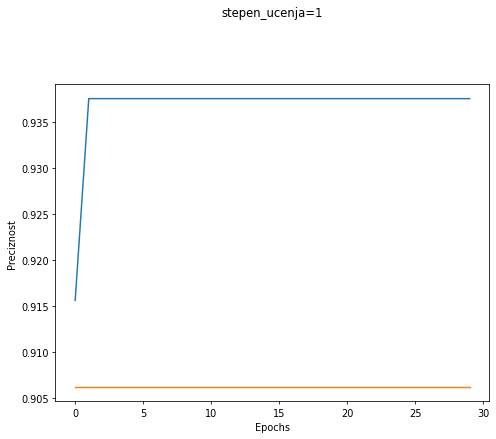

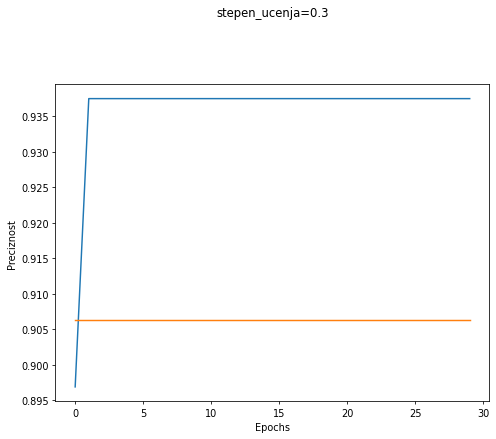

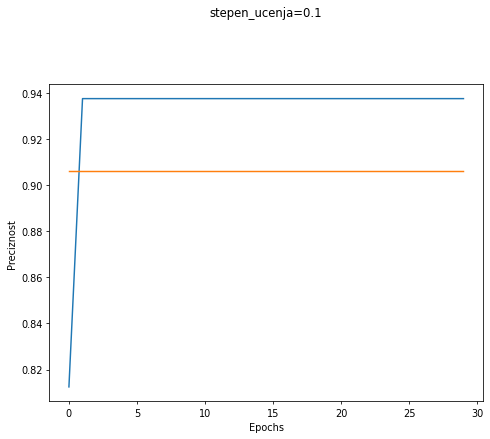

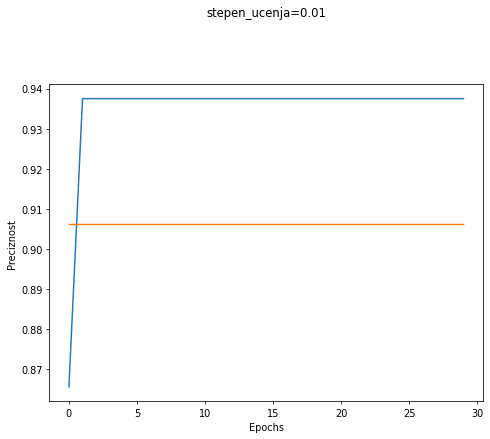

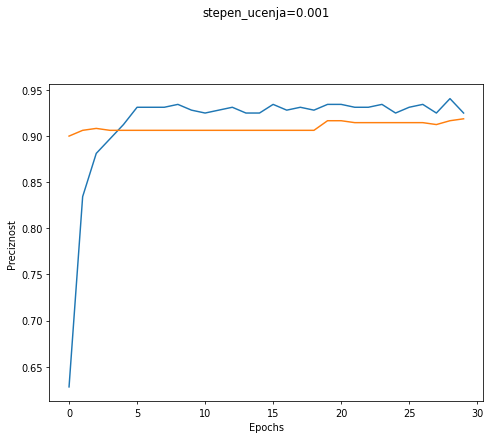

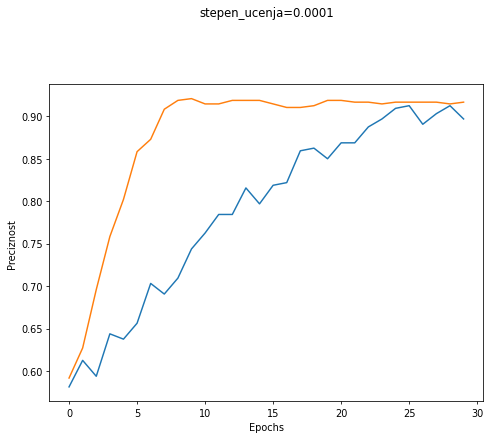

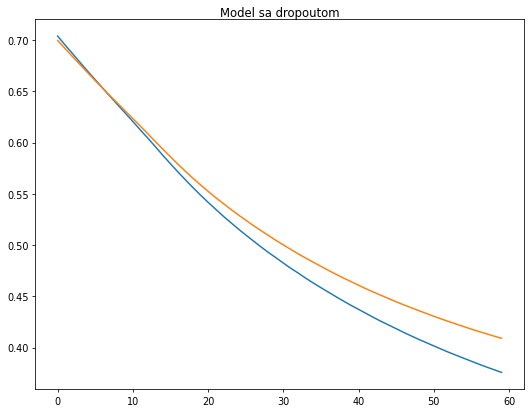

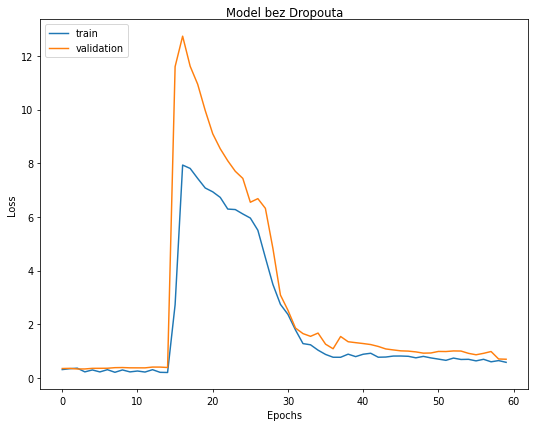

In [8]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

def identity(promenljiva):
  promenljiva = tf.convert_to_tensor(promenljiva)
  return tf.identity(promenljiva)

def simple_swish(features):
  features = tf.convert_to_tensor(features)
  return features * tf.nn.sigmoid

#Izracunava gradijent za model
def gradient(model,ulaz,izlaz):
	with tf.GradientTape() as tape:
		loss_vrednost=loss(model,ulaz,izlaz,trainging=True)
	return loss_vrednost, tape.gradient(loss_vrednost, model.trainable_variables)

#stepen ucenja
def prikaz_po_stepen_ucenja(ulazne_vrednost,x_train,y_train,x_test,y_test,stepen_ucenja):
	if stepen_ucenja==None:
		return 
	for i in (stepen_ucenja):
		print(i)
		m=get_model([8],ulazne_vrednost,i,MOMENTUM,EPOCHS,BATCH_SIZE,x_train,y_train,x_test,y_test)
		model = m.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, verbose=0)
		pyplot.figure(figsize=(8,6),dpi=70)  
		plt.ylabel('Preciznost')
		plt.xlabel('Epochs')
		pyplot.plot(model.history['accuracy'])
		pyplot.plot(model.history['val_accuracy'])
		pyplot.title('stepen_ucenja='+str(i), pad=70)
  
def napravi_nov_model(stepen_dropouta, ogranicenj_tezine,ulazne_vrednost,x_test,y_test):
	# create model
	model = Sequential()
	model.add(Dense(10, input_dim=ulazne_vrednost, kernel_initializer='uniform', activation='linear', kernel_constraint=maxnorm(ogranicenj_tezine)))
	model.add(Dense(3,activation='softmax',kernel_initializer='uniform',activity_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
	model.add(Dropout(stepen_dropouta))
	model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


	return model



def prikazi_modele(model,novi_model):
	pyplot.figure(figsize=(9,7),dpi=70)
	pyplot.plot(novi_model.history['loss'], label='train')
	pyplot.plot(novi_model.history['val_loss'], label='test')
	pyplot.title('Model sa dropoutom', pad=-80)

	pyplot.figure(figsize=(9,7),dpi=70)
	pyplot.plot(model.history['loss'], label='train')
	pyplot.plot(model.history['val_loss'], label='test')
	pyplot.title('Model bez Dropouta', pad=-80)

	plt.ylabel('Loss')
	plt.xlabel('Epochs')
	plt.legend(['train', 'validation'], loc='upper left')
#cuvaj_tezine(model,x_train,y_train,x_test,y_test)

ogranizenja_tezine = [1, 2, 3, 4, 5]
#On nam omogucava da smanimo loss funcion
stepen_droputa = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=stepen_droputa, weight_constraint=ogranizenja_tezine)

prikaz_po_stepen_ucenja(ulazne_vrednost,x_train,y_train,x_test,y_test,[1,0.3,0.1,0.01,0.001,0.0001])
novi_model=napravi_nov_model(stepen_droputa[0],ogranizenja_tezine[0],ulazne_vrednost,x_test,y_test)


mse , msa =novi_model.evaluate(x_test,y_test)
print('Model bez Dropouta - MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), msa))
mse , msa = model.evaluate(x_test,y_test)
print('Model sa Dropoutom - MSE: %.3f, RMSE: %.3f, MAE: %.3f' % (mse, sqrt(mse), msa))


stari_model=model.fit(x_train,y_train,BATCH_SIZE,validation_data=(x_test,y_test),epochs=60,verbose=0)
novi_model=novi_model.fit(x_train,y_train,BATCH_SIZE,validation_data=(x_test,y_test),epochs=60,verbose=0)

prikazi_modele(stari_model,novi_model)

